# Welcome to the OceanSpy demo
<img src="_static/oceanspy_logo_blue.png" width="50%" alt="OceanSpy">

* Press `Alt`+`r` to enter/exit presentation mode.
* Press `F11` to enter/exit full screen mode.
* Press `Space` to move to the next slide.  
* Press `Shift`+`Enter` to execute code.

## What is OceanSpy?
A Python package to facilitate ocean model data analysis and visualization.

## Ocean circulation models are becoming increasingly realistic, producing:
* Large volumes of data ⮕ [`Dask`](https://dask.org/)
* Labelled multi-dimensional arrays ⮕ [`xarray`](http://xarray.pydata.org/)
* Arrays on staggered grids ⮕ [`xgcm`](https://xgcm.readthedocs.io/)

### OceanSpy builds on software packages developed by the [<span style="color:#5eb130"><b>Pangeo</b></span>](https://pangeo.io/) community.
###### Pangeo tutorial @ 15:30

## Why OceanSpy? 
To analyze model data in the way observational oceanographers analyze field measurements.

<figure>
  <img src="_static/bams-d-18-0217.1-f2.jpeg"
       width="70%" alt="IGP">
  <figcaption>Figure from Renfrew et al., 2019.</figcaption>
</figure>

## How to use OceanSpy?
* Locally.
* On remote data-analysis clusters (e.g., [<span style="color:#002D72"><b>SciServer</b></span>](http://www.sciserver.org) or clouds).
![SciServer.png](_static/SciServer.png)

# Demo dataset

<figure>
  <img src="_static/jpo-d-17-0129.1-f1.jpeg"
       width="80%" alt="model">
  <figcaption>Figure from Almansi et al., 2017.</figcaption>
</figure>

Setup

In [1]:
# Import OceanSpy
import oceanspy as ospy

# Shift+Enter to execute the code.
# Space to continue.

In [2]:
import warnings
from pathlib import Path

import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt

# Import additional packages and change some defaults
import xarray as xr

big = True
xr.set_options(display_style="html")
mapsize = [10, 10] if big else [10, 5]
mpl.rcParams["figure.figsize"] = [15, 8] if big else [10, 5]
mpl.rcParams["font.size"] = 20 if big else 15
warnings.filterwarnings("ignore")

Open

In [3]:
# Import OceanDataset

# Download the data if you don't already have it. E.g., you're running the notebook in a non-binder environment.
path_to_file = "OSM2020_EGshelfIIseas2km_ERAI_1D"
path = Path(path_to_file)
if not (path.is_dir()):
    print(f"The folder {path_to_file} does not exist...downloading...")
    # myurl="https://livejohnshopkins-my.sharepoint.com/:u:/g/personal/malmans2_jh_edu/ETTi4yKjbvxOvraRKaydA3kBy_sOKNmkqGFP61CfsgW_bQ?"
    !wget -v -O tmp.tar.gz -L https://livejohnshopkins-my.sharepoint.com/:u:/g/personal/malmans2_jh_edu/ETTi4yKjbvxOvraRKaydA3kBy_sOKNmkqGFP61CfsgW_bQ?download=1
    !tar xvzf tmp.tar.gz
    !rm -f tmp.tar.gz
else:
    print(f"The folder {path_to_file} exists...reading...")

# Then read the data
od = ospy.open_oceandataset.from_zarr(path_to_file)

The folder OSM2020_EGshelfIIseas2km_ERAI_1D does not exist...downloading...
--2023-04-11 12:48:57--  https://livejohnshopkins-my.sharepoint.com/:u:/g/personal/malmans2_jh_edu/ETTi4yKjbvxOvraRKaydA3kBy_sOKNmkqGFP61CfsgW_bQ?download=1
Resolving livejohnshopkins-my.sharepoint.com (livejohnshopkins-my.sharepoint.com)... 13.107.138.8, 13.107.136.8, 2620:1ec:8fa::8, ...
Connecting to livejohnshopkins-my.sharepoint.com (livejohnshopkins-my.sharepoint.com)|13.107.138.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/malmans2_jh_edu/Documents/oceanspy/OSM2020_EGshelfIIseas2km_ERAI_1D.tar.gz?ga=1 [following]
--2023-04-11 12:48:57--  https://livejohnshopkins-my.sharepoint.com/personal/malmans2_jh_edu/Documents/oceanspy/OSM2020_EGshelfIIseas2km_ERAI_1D.tar.gz?ga=1
Reusing existing connection to livejohnshopkins-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 538432532 (513M) [application/x-gzip]
Saving to: ‘tmp.tar.gz’

tmp.tar

In [4]:
# Show OceanDataset
od

<oceanspy.OceanDataset>

Main attributes:
   .dataset: <xarray.Dataset>
   .grid: <xgcm.Grid>
   .projection: <Projected CRS: +proj=merc +ellps=WGS84 +lon_0=0.0 +x_0=0.0 +y_0=0 ...>

More attributes:
   .name: EGshelfIIseas2km_ERAI_1D
   .description: High-resolution (~2km) numerical simulation covering the east Greenland shelf (EGshelf), 
and the Iceland and Irminger Seas (IIseas) forced by ERA-Interim. 
   .parameters: <class 'dict'>
   .grid_coords: <class 'dict'>

xarray's Dataset

In [5]:
# List variables and metadata.
# Exit presentation mode (Alt+r) for better display.
od.dataset

<xarray.Dataset>
Dimensions:    (Y: 162, X: 143, time: 15, Z: 123, Yp1: 163, Xp1: 144, Zl: 123,
                Zp1: 124, Zu: 123, time_midp: 14)
Coordinates: (12/18)
  * X          (X) float64 -27.74 -27.7 -27.65 -27.61 ... -21.58 -21.54 -21.49
    XC         (Y, X) float64 dask.array<chunksize=(162, 143), meta=np.ndarray>
    XG         (Yp1, Xp1) float64 dask.array<chunksize=(163, 144), meta=np.ndarray>
    XU         (Y, Xp1) float64 dask.array<chunksize=(162, 144), meta=np.ndarray>
    XV         (Yp1, X) float64 dask.array<chunksize=(163, 143), meta=np.ndarray>
  * Xp1        (Xp1) float64 -27.76 -27.72 -27.67 ... -21.56 -21.52 -21.47
    ...         ...
  * Z          (Z) float64 -1.0 -3.5 -7.0 ... -1.716e+03 -1.732e+03 -1.746e+03
  * Zl         (Zl) float64 0.0 -2.0 -5.0 ... -1.709e+03 -1.724e+03 -1.739e+03
  * Zp1        (Zp1) float64 0.0 -2.0 -5.0 ... -1.724e+03 -1.739e+03 -1.754e+03
  * Zu         (Zu) float64 -2.0 -5.0 -9.0 ... -1.724e+03 -1.739e+03 -1.754e+03
  * time       (time) datetime64[ns] 2007-09-01 2007-09-03 ... 2007-09-29
  * time_midp  (time_midp) datetime64[ns] 2007-09-02 2007-09-04 ... 2007-09-28
Data variables: (12/26)
    Depth      (Y, X) float64 dask.array<chunksize=(162, 143), meta=np.ndarray>
    Eta        (time, Y, X) float64 dask.array<chunksize=(1, 162, 143), meta=np.ndarray>
    HFacC      (Z, Y, X) float64 dask.array<chunksize=(123, 162, 143), meta=np.ndarray>
    HFacS      (Z, Yp1, X) float64 dask.array<chunksize=(123, 163, 143), meta=np.ndarray>
    HFacW      (Z, Y, Xp1) float64 dask.array<chunksize=(123, 162, 144), meta=np.ndarray>
    S          (time, Z, Y, X) float64 dask.array<chunksize=(1, 123, 162, 143), meta=np.ndarray>
    ...         ...
    fCori      (Y, X) float64 dask.array<chunksize=(162, 143), meta=np.ndarray>
    fCoriG     (Yp1, Xp1) float64 dask.array<chunksize=(163, 144), meta=np.ndarray>
    rA         (Y, X) float64 dask.array<chunksize=(162, 143), meta=np.ndarray>
    rAs        (Yp1, X) float64 dask.array<chunksize=(163, 143), meta=np.ndarray>
    rAw        (Y, Xp1) float64 dask.array<chunksize=(162, 144), meta=np.ndarray>
    rAz        (Yp1, Xp1) float64 dask.array<chunksize=(163, 144), meta=np.ndarray>
Attributes:
    OceanSpy_description:    High-resolution (~2km) numerical simulation cove...
    OceanSpy_grid_coords:    {'Y': {'Y': None, 'Yp1': 0.5}, 'X': {'X': None, ...
    OceanSpy_grid_periodic:  []
    OceanSpy_name:           EGshelfIIseas2km_ERAI_1D
    OceanSpy_parameters:     {'rSphere': 6371.0, 'eq_state': 'jmd95', 'rho0':...
    OceanSpy_projection:     Mercator(**{})

Plot bathymetry

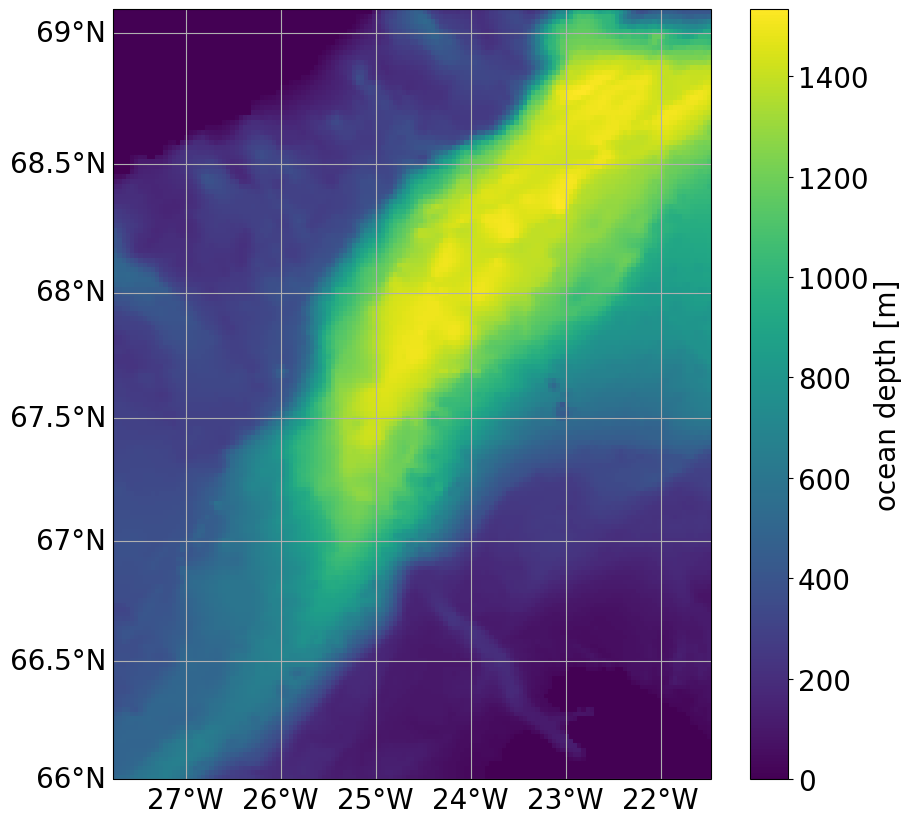

In [6]:
# Note: Automatically projected using od.projection
fig = plt.figure(figsize=mapsize)
ax = od.plot.horizontal_section(varName="Depth")

# Use case: Kögur
<figure>
  <img src="_static/array2.png"
       width="50%" alt="Kogur" style="background-color: #1c4966;">
  <figcaption>From http://kogur.whoi.edu/</figcaption>
</figure>

## OceanSpy mooring array
<figure>
  <img src="_static/Kogur_15_1.png"
       width="70%" alt="Kogur model">
  <figcaption>From https://oceanspy.readthedocs.io/en/latest/Kogur.html</figcaption>
</figure>

Extract mooring array

In [7]:
# Kögur coordinates
lats_Kogur = [68.68, 67.52, 66.49]
lons_Kogur = [-26.28, -23.77, -22.99]

# Extract mooring array
od_moor = od.subsample.mooring_array(Xmoor=lons_Kogur, Ymoor=lats_Kogur)

Cutting out the oceandataset.
Extracting mooring array.


Plot moorings

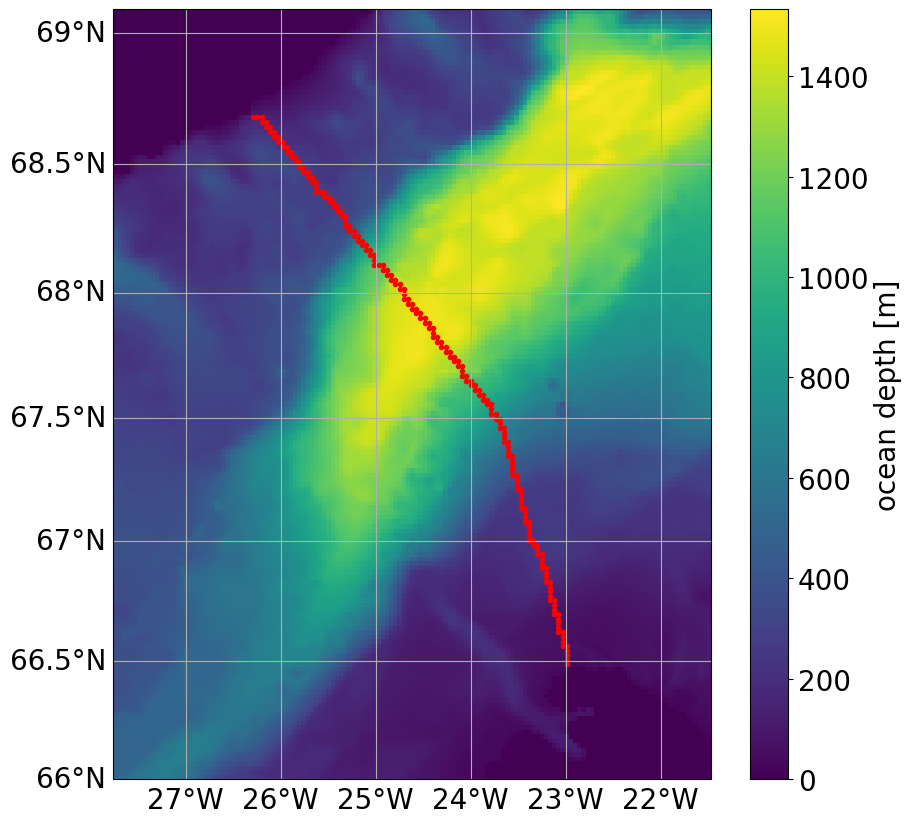

In [8]:
# Show the array on top of bathymetry
fig = plt.figure(figsize=mapsize)
ax = od.plot.horizontal_section(varName="Depth")
X, Y = od_moor.dataset["XC"].squeeze(), od_moor.dataset["YC"].squeeze()
line = ax.plot(X, Y, "r.", transform=ccrs.PlateCarree())

T/S diagram (density needs to be computed!)

Computing weighted_mean.
Computing weighted_mean.
Isopycnals: Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.


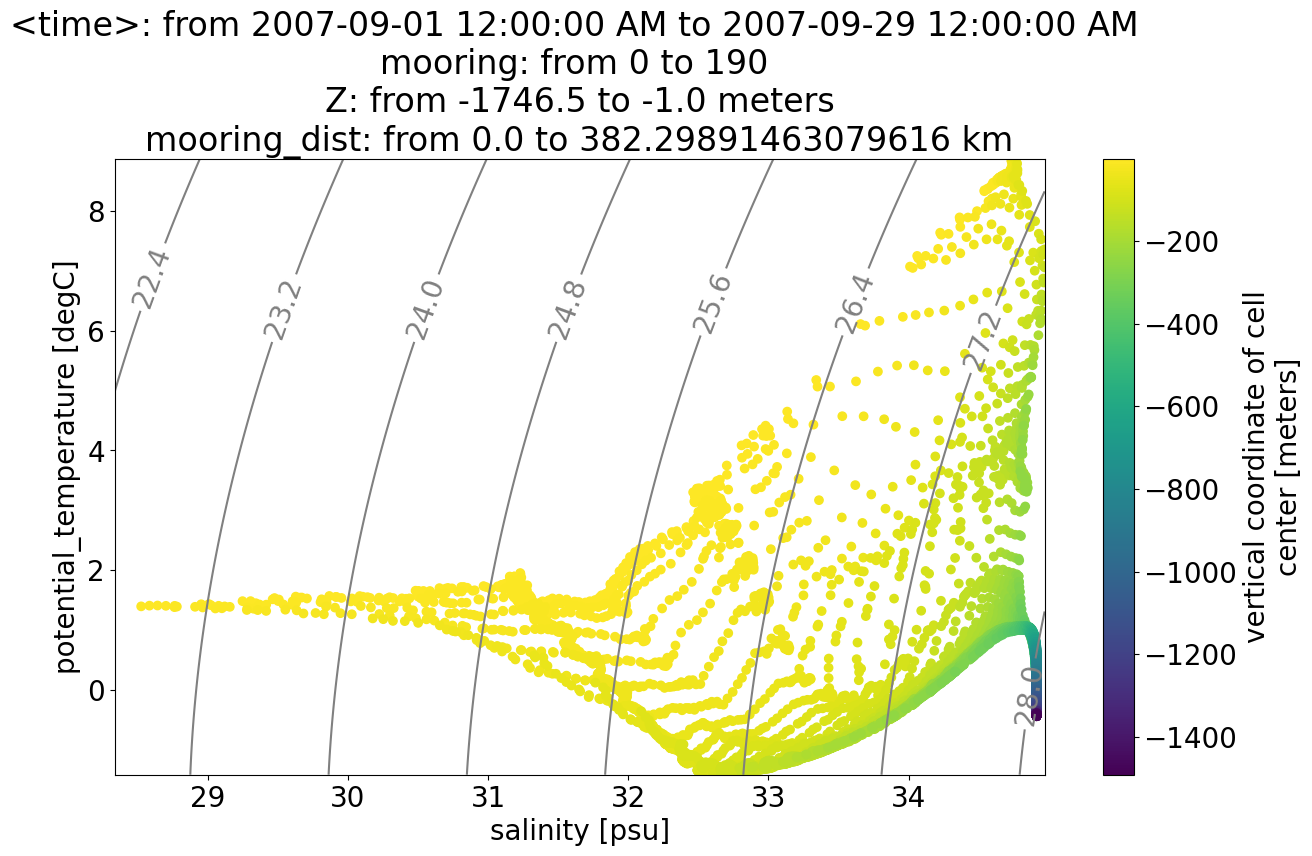

In [9]:
# T/S diagram color-coded by depth (averaged over time).
ax = od_moor.plot.TS_diagram(colorName="Z", meanAxes="time")

Animated T/S diagram

In [10]:
# Using .animate instead of .plot
anim = od_moor.animate.TS_diagram(colorName="Z")
plt.close()

Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.


16it [00:27,  1.94s/it]            

16it [00:29,  1.86s/it]


## OceanSpy ship survey
<figure>
  <img src="_static/aoY1Qa3w-1024x683.jpeg"
       width="65%" alt="survey">
  <figcaption>From https://web.whoi.edu/all0118</figcaption>
</figure>

Extract ship survey

In [11]:
# Extract survey overlapping the mooring array
# Note: This function interpolates, getting rid of staggered grids
varList = ["Temp", "S", "U", "V"]
od_surv = od.subsample.survey_stations(
    Xsurv=lons_Kogur, Ysurv=lats_Kogur, delta=2, varList=varList
)

# Change background color
mpl.rcParams["axes.facecolor"] = ".25"

Cutting out the oceandataset.
Carrying out survey.
Variables to interpolate: ['S', 'Temp', 'U', 'V', 'XC', 'XG', 'XU', 'XV', 'YC', 'YG', 'YU', 'YV', 'Xind', 'Yind'].
Interpolating [S].
Interpolating [Temp].
Interpolating [U].
Interpolating [V].
Interpolating [XC].
Interpolating [XG].
Interpolating [XU].
Interpolating [XV].
Interpolating [YC].
Interpolating [YG].
Interpolating [YU].
Interpolating [YV].
Interpolating [Xind].
Interpolating [Yind].


Show vertical section

Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.
Computing weighted_mean.
Computing weighted_mean.


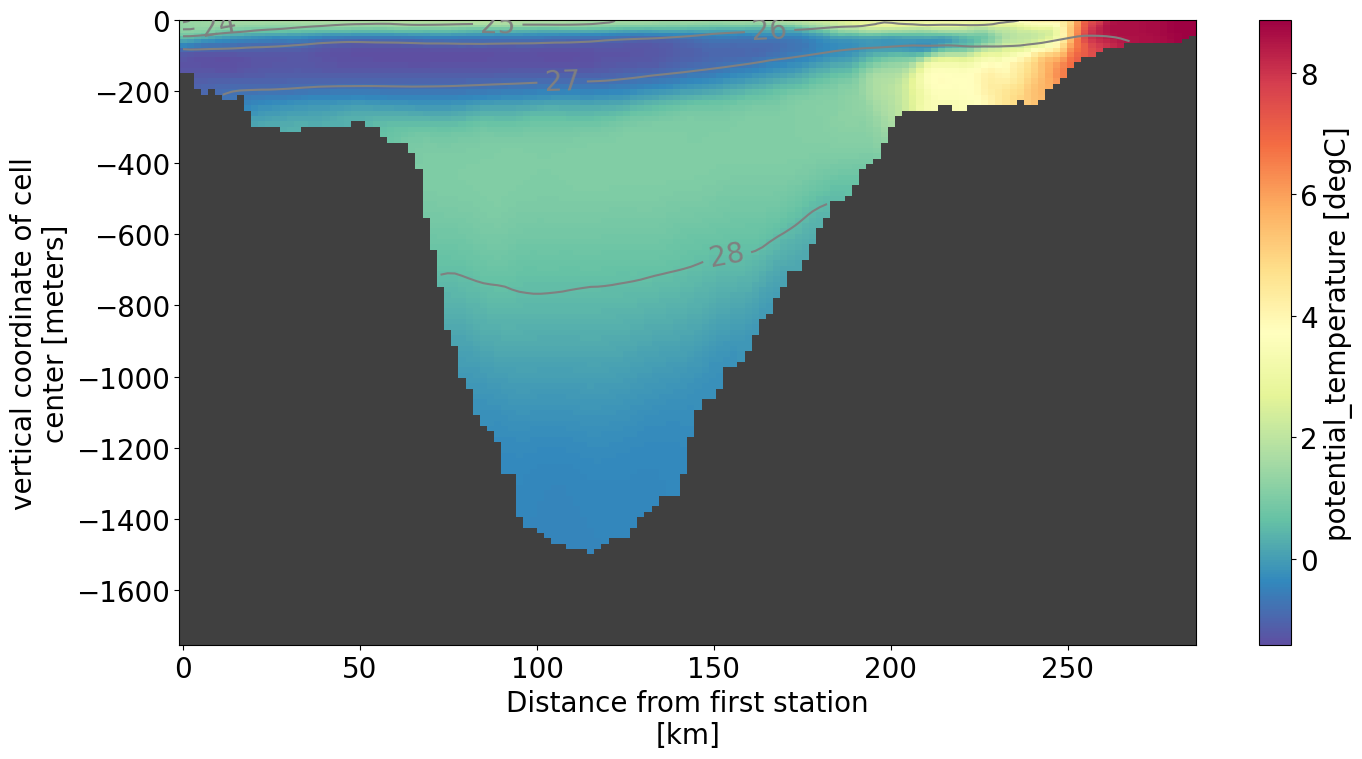

In [12]:
# Vertical section of temperature with isopycnals
xr_kwargs = dict(center=False, cmap="Spectral_r")
ax = od_surv.plot.vertical_section(
    varName="Temp", contourName="Sigma0", meanAxes="time", **xr_kwargs
)

Rotate velocities

In [13]:
# Switch reference system to cross/along-section
od_surv = od_surv.compute.survey_aligned_velocities()

Computing survey aligned velocities.


Show through section velocity

In [14]:
# Animation of velocity orthogonal to the section
xr_kwargs = dict(robust=True)
anim = od_surv.animate.vertical_section(
    varName="ort_Vel", contourName="Sigma0", **xr_kwargs
)
plt.close()

16it [00:28,  1.79s/it]            

16it [00:29,  1.84s/it]


# OceanSpy diagnostics overview
<figure>
  <img src="_static/joss_table.png"
       width="55%" alt="JOSStable">
  <figcaption>Table from Almansi et al., 2019.</figcaption>
</figure>

Compute Ertel PV: $\displaystyle{Q = - \frac{\omega \cdot \nabla \rho}{\rho}  =}\displaystyle{(f + \zeta)\frac{N^2}{g} + \frac{\left(\zeta_H+e\hat{\mathbf{y}}\right)\cdot\nabla_H\rho}{\rho_0}}$

In [15]:
# Compute Ertel PV in the top 100m
od100m = od.subsample.cutout(ZRange=[0, -100])
od100m = od100m.compute.Ertel_potential_vorticity()

Cutting out the oceandataset.
Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.
Computing Brunt-Väisälä Frequency using the following parameters: {'rho0': 1027, 'g': 9.81}.
Computing gradient.
Computing relative vorticity.
Computing curl.
Computing gradient.
Computing gradient.
Computing gradient.
Computing gradient.
Computing Ertel potential vorticity using the following parameters: {'rho0': 1027, 'g': 9.81, 'omega': 7.292123516990375e-05}.
Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.
Computing gradient.


In [16]:
# Plot Ertel PV (averaged over Z).
# Note: The vertical mean is automatically weighted.
fig = plt.figure(figsize=mapsize)
xr_kwargs = dict(robust=True, center=False, cmap="inferno")
anim = od100m.animate.horizontal_section(varName="Ertel_PV", meanAxes="Z", **xr_kwargs)
plt.close()

16it [00:22,  1.43s/it]            

16it [00:23,  1.48s/it]


# More info:
* OceanSpy documentation:  
[<span style="color:#0081BC"><b>https://oceanspy.readthedocs.io</b></span>](https://oceanspy.readthedocs.io)
* OceanSpy GitHub:  
[<span style="color:#0081BC"><b>https://github.com/hainegroup/oceanspy</b></span>](https://github.com/hainegroup/oceanspy)
* JOSS paper:  
[<span style="color:#0081BC"><b>https://doi.org/10.21105/joss.01506</b></span>](https://doi.org/10.21105/joss.01506)
* SciServer:  
[<span style="color:#0081BC"><b>http://www.sciserver.org</b></span>](http://www.sciserver.org)
* Poseidon project:  
[<span style="color:#0081BC"><b>https://poseidon.idies.jhu.edu</b></span>](https://poseidon.idies.jhu.edu)

# More info:
* OceanSpy documentation:  
[<span style="color:#0081BC"><b>https://oceanspy.readthedocs.io</b></span>](https://oceanspy.readthedocs.io)
* OceanSpy GitHub:  
[<span style="color:#0081BC"><b>https://github.com/hainegroup/oceanspy</b></span>](https://github.com/hainegroup/oceanspy)
* JOSS paper:  
[<span style="color:#0081BC"><b>https://doi.org/10.21105/joss.01506</b></span>](https://doi.org/10.21105/joss.01506)
* SciServer:  
[<span style="color:#0081BC"><b>http://www.sciserver.org</b></span>](http://www.sciserver.org)
* Poseidon project:  
[<span style="color:#0081BC"><b>https://poseidon.idies.jhu.edu</b></span>](https://poseidon.idies.jhu.edu)